In [1]:
import sys
sys.path.append("...")
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import ACTIVITIES, ABBR, TZ_PARIS, TZ_LONDON
from src.viz_style import apply_nature_style

apply_nature_style()

In [3]:
from src.utils_time import to_local_time_series, split_cross_midnight, week_start_monday
from src.utils_split import split_users_by_hash
from src.regularity import regularity_report, summarize_reg, compute_user_hex_stats, infer_home_work_anchors, make_hex_lookup

In [4]:
from pathlib import Path

DATA_DIR = Path("/Users/pang/Codes/GISRUK")
PARIS_TRIPS_PATH = DATA_DIR / "assets/move/paris/paris_trips_h3.parquet"   # 你确认过
OUT_DIR = DATA_DIR / "outputs" / "data"
OUT_DIR.mkdir(parents=True, exist_ok=True)

trips = pd.read_parquet(PARIS_TRIPS_PATH)
print("Trips rows:", len(trips), "users:", trips["ID"].nunique())
print("Columns:", list(trips.columns)[:15], "...")

Trips rows: 76587 users: 3333
Columns: ['KEY', 'ID', 'Day_EMG', 'Date_EMG', 'Day_Type', 'ID_Trip_Days', 'Type_Trip_OD', 'Area_O', 'Area_D', 'Code_INSEE_O', 'Code_INSEE_D', 'Zone_O', 'Zone_D', 'Date_O', 'Time_O'] ...


In [5]:
def looks_like_h3(x: str) -> bool:
    if not isinstance(x, str): return False
    x = x.strip()
    return x.startswith("8") and len(x) >= 10

def detect_hex_col(df: pd.DataFrame):
    candidates = ["d_h10","o_h10","Zone_D","Zone_O","hex_id","h3","h10"]
    for c in candidates:
        if c in df.columns:
            s = df[c].dropna().astype(str)
            if len(s)==0:
                continue
            rate = s.map(looks_like_h3).mean()
            if rate > 0.5:
                print("Detected hex column:", c, "H3-like rate:", rate)
                return c
    raise ValueError("Cannot detect H3 hex column automatically. Please specify manually.")

hex_col = detect_hex_col(trips)

Detected hex column: d_h10 H3-like rate: 1.0


In [6]:
import re

PURPOSE_MAP = {
    "DEPART_HOME": "HOME",
    "RETURN_HOME": "HOME",
    "WORK": "WORK",
    "BUSINESS": "WORK",
    "STUDIES": "STUDY",
    "PURCHASE": "PURCHASE",
    "LEISURE": "LEISURE",
    "HEALTH": "HEALTH",
    "OTHER": "OTHER",
    "ACCOM": "OTHER",
}

def _norm(x) -> str:
    if pd.isna(x): return ""
    s = str(x).strip().upper()
    s = re.sub(r"[\s\-]+", "_", s)
    return s

def map_purpose(x):
    return PURPOSE_MAP.get(_norm(x), None)

In [7]:
def make_dt(date_series, time_series):
    return pd.to_datetime(date_series.astype(str) + " " + time_series.astype(str), errors="coerce")

t = trips.copy()
t["_dt_o"] = make_dt(t["Date_O"], t["Time_O"])
t["_dt_d"] = make_dt(t["Date_D"], t["Time_D"])

t["_ao"] = t["Purpose_O"].apply(map_purpose) if "Purpose_O" in t.columns else None
t["_ad"] = t["Purpose_D"].apply(map_purpose)

t["_trip_dur_min"] = (t["_dt_d"] - t["_dt_o"]).dt.total_seconds()/60.0

qa = {
    "rows": len(t),
    "users": t["ID"].nunique(),
    "missing_dt_o_rate": float(t["_dt_o"].isna().mean()),
    "missing_dt_d_rate": float(t["_dt_d"].isna().mean()),
    "missing_hex_rate": float(t[hex_col].isna().mean()),
    "missing_purposeD_map_rate": float(t["_ad"].isna().mean()),
    "neg_or_zero_trip_dur_rate": float((t["_trip_dur_min"] <= 0).mean()),
    "trip_dur_p50": float(t["_trip_dur_min"].quantile(0.5)),
    "trip_dur_p95": float(t["_trip_dur_min"].quantile(0.95)),
    "trip_dur_p99": float(t["_trip_dur_min"].quantile(0.99)),
}

print(pd.Series(qa))

# per-user horizon (unique dates)
t["_date_o"] = t["_dt_o"].dt.date
days_per_user = t.groupby("ID")["_date_o"].nunique()
print("\nDays per user (unique origin dates):")
print(days_per_user.describe(percentiles=[0.1,0.5,0.9]))
print("share == 7:", float((days_per_user==7).mean()))

rows                         76587.000000
users                         3333.000000
missing_dt_o_rate                0.000000
missing_dt_d_rate                0.000000
missing_hex_rate                 0.090068
missing_purposeD_map_rate        0.000000
neg_or_zero_trip_dur_rate        0.000000
trip_dur_p50                    16.000000
trip_dur_p95                    72.000000
trip_dur_p99                   119.000000
dtype: float64

Days per user (unique origin dates):
count    3333.000000
mean        5.832583
std         1.188250
min         1.000000
10%         4.000000
50%         6.000000
90%         7.000000
max         8.000000
Name: _date_o, dtype: float64
share == 7: 0.35313531353135313


In [8]:
MAX_TRIP_DUR_MIN = 360  # 6 hours, conservative
REQUIRE_HEX = True

clean = t.copy()
clean = clean[clean["_dt_o"].notna() & clean["_dt_d"].notna()].copy()
clean = clean[(clean["_trip_dur_min"] > 0) & (clean["_trip_dur_min"] <= MAX_TRIP_DUR_MIN)].copy()
clean = clean[clean["_ad"].notna()].copy()
if REQUIRE_HEX:
    clean = clean[clean[hex_col].notna() & (clean[hex_col].astype(str).str.len() > 0)].copy()

print("After light cleaning:", len(clean), "rows,", clean["ID"].nunique(), "users")

After light cleaning: 69661 rows, 3322 users


In [9]:
MIN_DAYS_PER_USER = 4  # keep users with >=4 active days (<=3 removed)

clean_u = clean.copy()
clean_u["_date_o"] = clean_u["_dt_o"].dt.date

days_per_user_clean = clean_u.groupby("ID")["_date_o"].nunique()

print("Days per user (after trip-level cleaning):")
print(days_per_user_clean.describe(percentiles=[0.1,0.5,0.9]))

bad_users = set(days_per_user_clean[days_per_user_clean < MIN_DAYS_PER_USER].index.astype(str))
print(f"Users with <{MIN_DAYS_PER_USER} active days:", len(bad_users), f"({len(bad_users)/clean_u['ID'].nunique():.2%})")

# filter them out
before_rows, before_users = len(clean_u), clean_u["ID"].nunique()
clean = clean_u[~clean_u["ID"].astype(str).isin(bad_users)].copy()
after_rows, after_users = len(clean), clean["ID"].nunique()

print("Filtered trips:", before_rows, "->", after_rows)
print("Filtered users:", before_users, "->", after_users)

Days per user (after trip-level cleaning):
count    3322.000000
mean        5.663456
std         1.278189
min         1.000000
10%         4.000000
50%         6.000000
90%         7.000000
max         8.000000
Name: _date_o, dtype: float64
Users with <4 active days: 219 (6.59%)
Filtered trips: 69661 -> 67735
Filtered users: 3322 -> 3103


In [10]:
MAX_STAY_HOURS = 36

clean2 = clean.sort_values(["ID","_dt_o"]).copy()
clean2["_next_dt_o"] = clean2.groupby("ID")["_dt_o"].shift(-1)

rows=[]
max_min = MAX_STAY_HOURS * 60

for uid, g in clean2.groupby("ID", sort=False):
    g = g.reset_index(drop=True)
    for k in range(len(g)-1):
        arrive = g.loc[k, "_dt_d"]
        depart = g.loc[k, "_next_dt_o"]
        if pd.isna(arrive) or pd.isna(depart):
            continue
        dur = (depart - arrive).total_seconds()/60.0
        if dur <= 0 or dur > max_min:
            continue
        h = g.loc[k, hex_col]
        if pd.isna(h) or str(h).strip() in ["", "nan"]:
            continue
        rows.append((uid, arrive, depart, dur, str(h), g.loc[k, "_ad"]))

paris_stays = pd.DataFrame(rows, columns=["user_id","start_time","end_time","duration_min","hex_id","y_true"])

print("Stays rows:", len(paris_stays), "users:", paris_stays["user_id"].nunique())
print("\nDuration stats (min):")
print(paris_stays["duration_min"].describe(percentiles=[0.5,0.9,0.95,0.99]))
print("\nLabel distribution:")
print(paris_stays["y_true"].value_counts())

Stays rows: 62240 users: 3103

Duration stats (min):
count    62240.000000
mean       326.855929
std        394.282352
min          1.000000
50%        139.000000
90%        921.000000
95%       1155.000000
99%       1495.610000
max       2159.000000
Name: duration_min, dtype: float64

Label distribution:
HOME        20818
WORK        12740
OTHER       10020
PURCHASE     9360
LEISURE      6427
HEALTH       1522
STUDY        1353
Name: y_true, dtype: int64


In [11]:
train_users, valid_users = split_users_by_hash(paris_stays["user_id"], 0.8)

stays_train = paris_stays[paris_stays["user_id"].isin(train_users)].copy()
stays_valid = paris_stays[paris_stays["user_id"].isin(valid_users)].copy()

print("Train users:", len(train_users), "Train stays:", len(stays_train))
print("Valid users:", len(valid_users), "Valid stays:", len(stays_valid))

train_path = OUT_DIR / "paris_stays_train.parquet"
valid_path = OUT_DIR / "paris_stays_valid.parquet"
stays_train.to_parquet(train_path, index=False)
stays_valid.to_parquet(valid_path, index=False)
print("Saved:", train_path)
print("Saved:", valid_path)

Train users: 2482 Train stays: 49803
Valid users: 621 Valid stays: 12437
Saved: /Users/pang/Codes/GISRUK/outputs/data/paris_stays_train.parquet
Saved: /Users/pang/Codes/GISRUK/outputs/data/paris_stays_valid.parquet


Saved: /Users/pang/Codes/GISRUK/outputs/figures/paris_patterns_by_dow.png


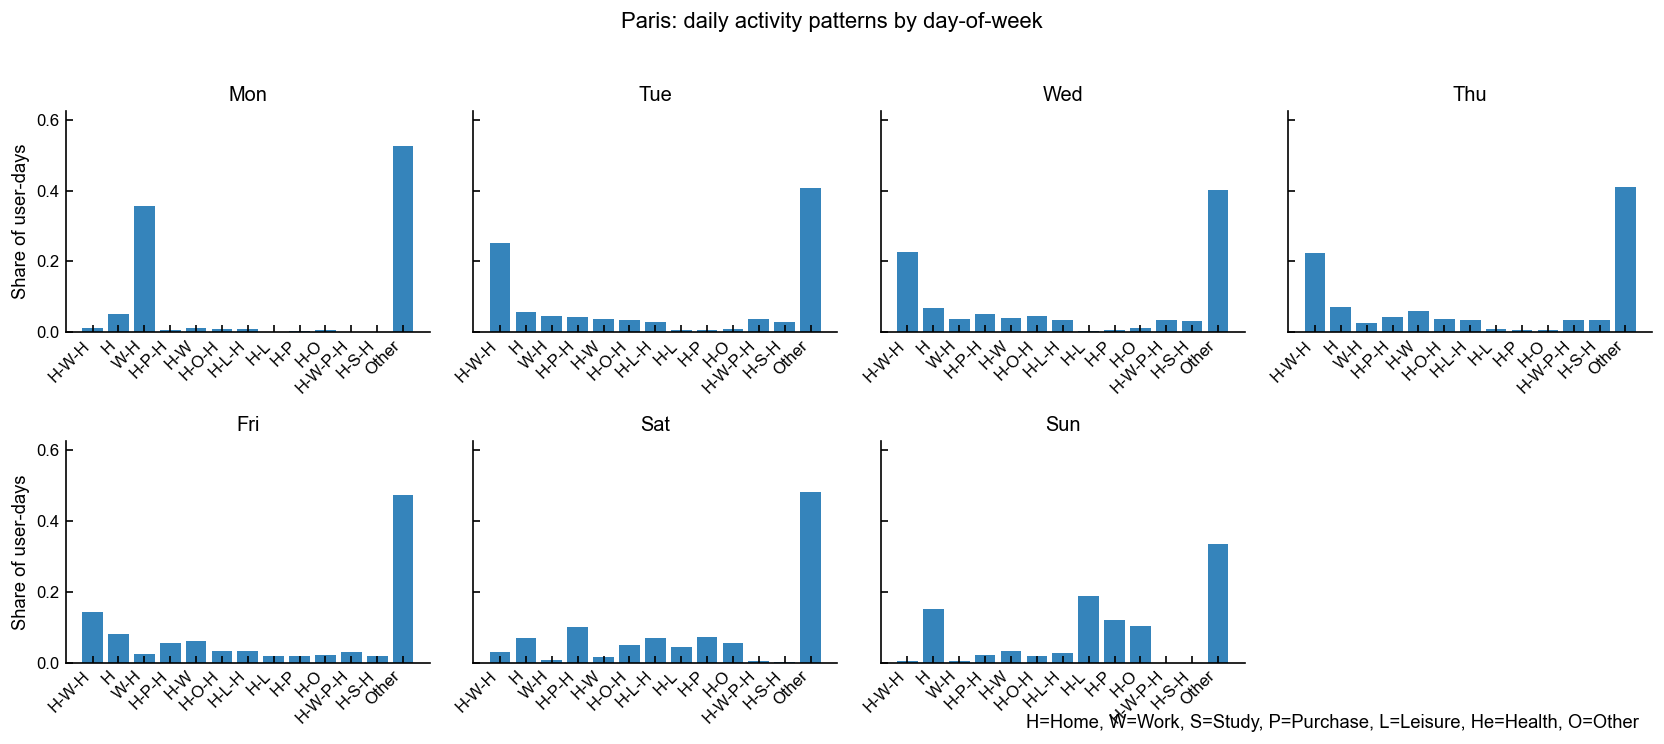

In [12]:
def collapse_consecutive(labels):
    out=[]
    for x in labels:
        if len(out)==0 or x!=out[-1]:
            out.append(x)
    return out

def build_daily_patterns(stays_df, label_col="y_true", min_dur_min=10, require_home_sandwich=False):
    d = stays_df.copy()
    d["start_time"] = to_local_time_series(d["start_time"], tz=TZ_PARIS, assume_utc_if_naive=False)
    d["end_time"]   = to_local_time_series(d["end_time"], tz=TZ_PARIS, assume_utc_if_naive=False)
    d["duration_min"] = pd.to_numeric(d["duration_min"], errors="coerce")
    d = d.dropna(subset=["user_id","start_time","end_time","duration_min",label_col]).copy()
    d = d[d["duration_min"] > 0].copy()

    d = split_cross_midnight(d)
    d = d[d["duration_min"] >= float(min_dur_min)].copy()

    d["date"] = d["start_time"].dt.date
    d["dow"] = d["start_time"].dt.weekday

    rows=[]
    for (u, date), g in d.groupby(["user_id","date"], sort=False):
        g = g.sort_values("start_time")
        labs = [x for x in g[label_col].astype(str).tolist() if x in ABBR]
        if not labs:
            continue
        labs2 = collapse_consecutive(labs)
        if require_home_sandwich and not (labs2[0]=="HOME" and labs2[-1]=="HOME"):
            continue
        patt = "-".join([ABBR[x] for x in labs2])
        rows.append((u, date, int(g["dow"].iloc[0]), patt))
    return pd.DataFrame(rows, columns=["user_id","date","dow","pattern"])

patterns = build_daily_patterns(paris_stays, label_col="y_true", min_dur_min=10, require_home_sandwich=False)

def select_patterns_by_coverage(patterns_df, coverage=0.90, max_n=200, min_count=20):
    vc = patterns_df["pattern"].value_counts()
    vc = vc[vc >= min_count]
    cum = vc.cumsum() / vc.sum()
    selected = vc.index[cum <= coverage].tolist()
    if len(selected) == 0:
        selected = vc.head(min(max_n, len(vc))).index.tolist()
    else:
        selected = selected[:max_n]
    return selected

def plot_patterns_by_dow_small_multiples(patterns_df, coverage=0.90, max_n=12, min_count=20,
                                        title="Paris: daily activity patterns by day-of-week",
                                        outpath=None):
    apply_nature_style()
    dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

    keep = select_patterns_by_coverage(patterns_df, coverage=coverage, max_n=200, min_count=min_count)
    tmp = patterns_df.copy()
    tmp["pattern2"] = tmp["pattern"].where(tmp["pattern"].isin(keep), other="Other")
    global_counts = tmp["pattern2"].value_counts()
    ordered = global_counts.index.tolist()
    top_order = [p for p in ordered if p != "Other"][:max_n]
    if "Other" in ordered:
        top_order = top_order + ["Other"]

    tab = tmp.groupby(["dow","pattern2"]).size().unstack(fill_value=0).reindex(index=range(7), fill_value=0)
    tab = tab.reindex(columns=top_order, fill_value=0)
    share = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

    fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharey=True)
    axes = axes.flatten()
    x = np.arange(len(top_order))

    for d in range(7):
        ax = axes[d]
        ax.bar(x, share.loc[d].values, alpha=0.9)
        ax.set_title(dow_names[d])
        ax.set_ylim(0, min(1.0, float(share.values.max())*1.15 + 0.02))
        ax.tick_params(direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xticks(x)
        ax.set_xticklabels(top_order, rotation=45, ha="right")
        if d % 4 == 0:
            ax.set_ylabel("Share of user-days")

    axes[7].axis("off")
    fig.suptitle(title, y=1.02)

    legend_text = "H=Home, W=Work, S=Study, P=Purchase, L=Leisure, He=Health, O=Other"
    fig.text(0.98, 0.02, legend_text, ha="right", va="bottom", fontsize=11)
    fig.subplots_adjust(hspace=0.40, wspace=0.05)

    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
        print("Saved:", outpath)
    plt.show()
    plt.close(fig)

out_fig = DATA_DIR / "outputs" / "figures"
out_fig.mkdir(parents=True, exist_ok=True)
plot_patterns_by_dow_small_multiples(patterns, coverage=0.90, max_n=12, min_count=20,
                                    outpath=str(out_fig / "paris_patterns_by_dow.png"))

In [14]:
patterns["pattern"].value_counts().head(10)

H-W-H    1860
H         996
W-H       953
H-P-H     626
H-W       512
H-O-H     452
H-L-H     451
H-L       408
H-P       370
H-O       346
Name: pattern, dtype: int64